In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import category_encoders as ce
from matplotlib import pyplot

In [96]:
df = pd.read_csv("../data/final_data.csv")
df

,number,incident_state,reassignment_count,reopen_count,sys_mod_count,made_sla,impact,priority,knowledge,u_priority_confirmation,assignment_group,category,subcategory,time_taken_since_open,time_from_prev,time_req_to_close
0,INC0000045,New,0,0,0,True,2,3,True,False,Group 56,Category 55,Subcategory 170,7.0,7.0,7837.0
1,INC0000045,Resolved,0,0,2,True,2,3,True,False,Group 56,Category 55,Subcategory 170,457.0,450.0,7387.0
2,INC0000045,Resolved,0,0,3,True,2,3,True,False,Group 56,Category 55,Subcategory 170,613.0,156.0,7231.0
3,INC0000047,New,0,0,0,True,2,3,True,False,Group 70,Category 40,Subcategory 215,17.0,17.0,8943.0
4,INC0000047,Active,1,0,1,True,2,3,True,False,Group 24,Category 40,Subcategory 215,50.0,33.0,8910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116789,INC0120835,Active,1,0,1,True,2,3,False,False,Group 31,Category 42,Subcategory 223,2.0,2.0,42.0
116790,INC0120835,Resolved,1,0,3,True,2,3,False,True,Group 31,Category 42,Subcategory 223,44.0,42.0,0.0
116791,INC0121064,Active,0,0,0,True,2,3,False,False,Group 70,Category 42,Subcategory 223,0.0,0.0,141.0
116792,INC0121064,Active,1,0,1,True,2,3,False,False,Group 31,Category 42,Subcategory 223,63.0,63.0,78.0


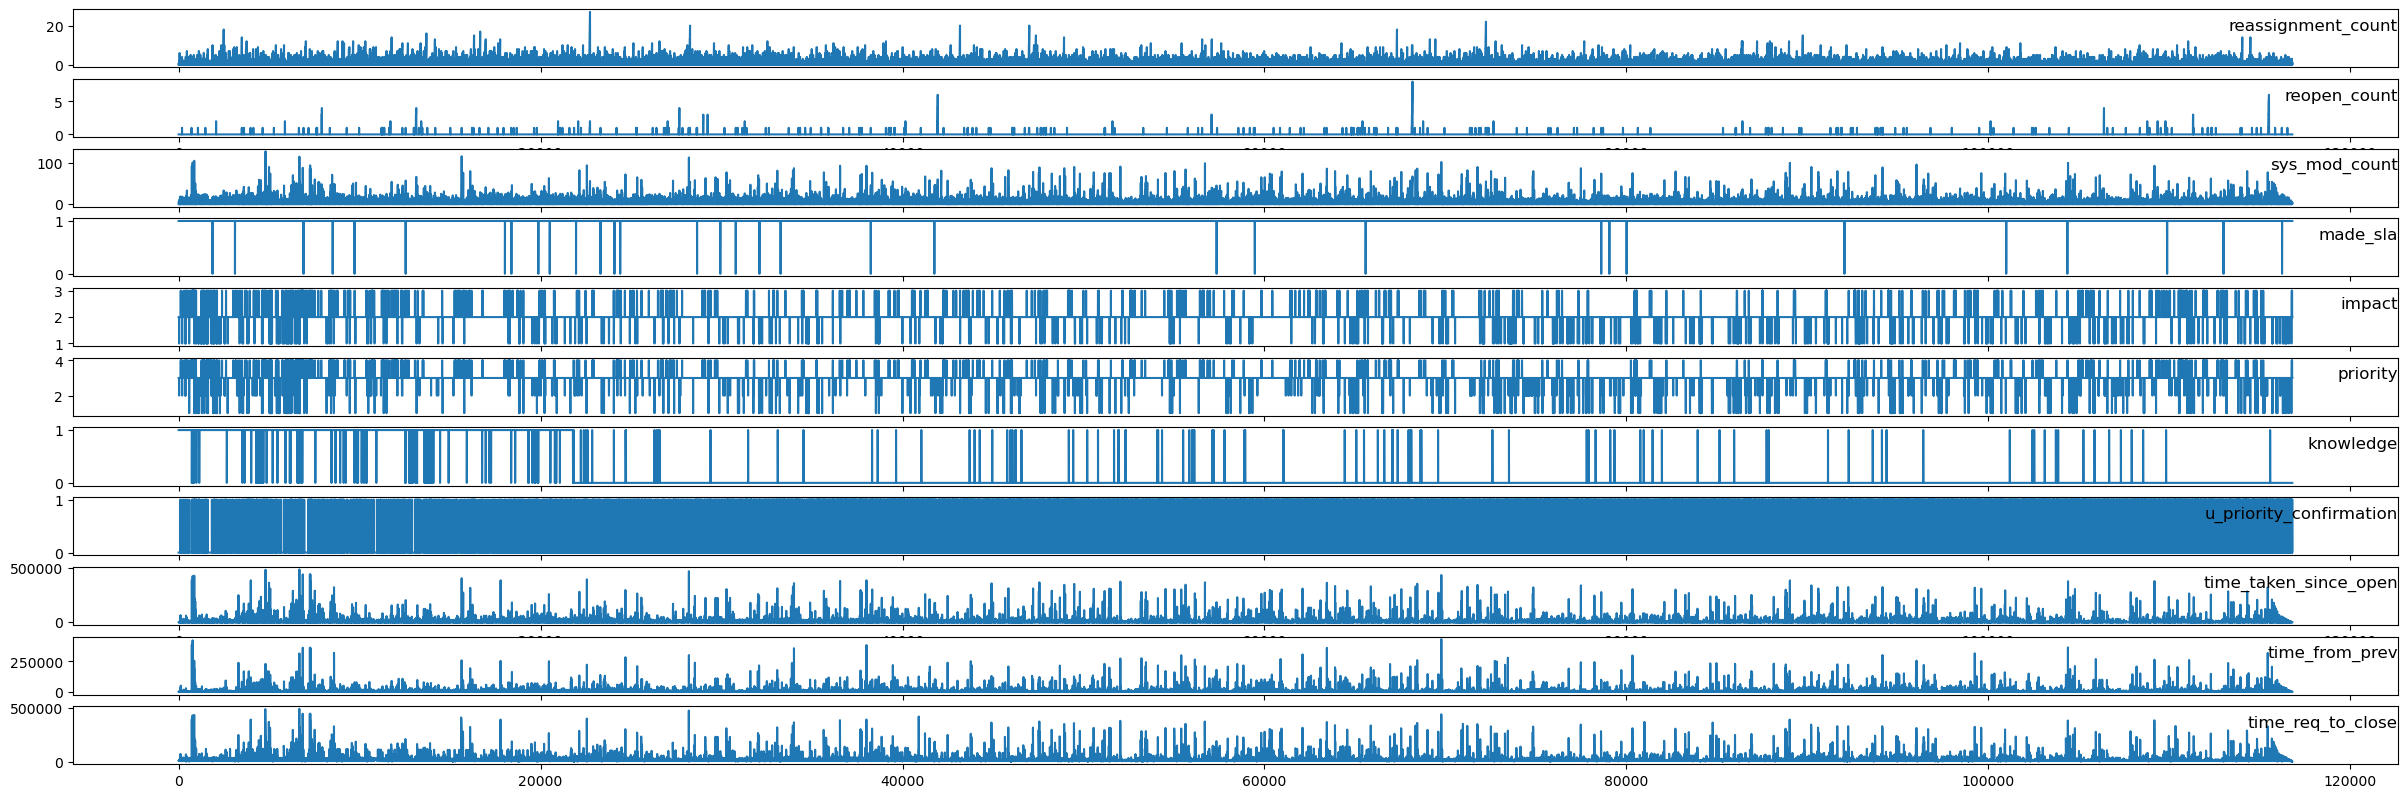

In [97]:
# plot each column
pyplot.figure(figsize=(30, 10), dpi=100)
groups= ['reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'impact', 'priority', 'knowledge',
       'u_priority_confirmation', 'time_taken_since_open', 'time_from_prev',
       'time_req_to_close']
i=1
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(df[[group]])
	pyplot.title(group, y=0.5, loc='right')
	i += 1
pyplot.show()

In [98]:
df1 = df.drop(["u_priority_confirmation" 
              ]
             ,axis=1)

In [99]:
time_steps = df.groupby("number").size().max()
time_steps

57

In [100]:
cols = df.columns.tolist()

Padding incidents

In [101]:
mdf= pd.concat([
    d.reset_index(drop=True).reindex(range(time_steps)).assign(number=n)
    for n, d in df.groupby('number')
], ignore_index=True)
mdf=mdf.fillna(0)

In [110]:
#Split data into train test
test_rows = 2491*time_steps #10% data for testing
values=mdf.values
train_rows=values.shape[0] - test_rows

train = mdf.iloc[:train_rows, :].copy()
test = mdf.iloc[train_rows:, :].copy()

#STandard SCalar for normalizing numeric data. Binary Encoding for String based features
rbs = StandardScaler()
be = ce.BinaryEncoder()
float_col_list = ['reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'impact', 'priority', 'knowledge',
       'u_priority_confirmation', 'time_taken_since_open', 'time_from_prev',
       'time_req_to_close']


train.loc[:,float_col_list]=rbs.fit_transform(train.loc[:,float_col_list])
train = be.fit_transform(train.iloc[:,1:])

test.loc[:,float_col_list]=rbs.transform(test.loc[:,float_col_list])
test = be.transform(test.iloc[:,1:])

In [111]:
train_values = train.values
test_values = test.values

# split into input and outputs
train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((-1, time_steps, train_X.shape[1]))
train_y = train_y.reshape((-1,time_steps,1))

test_X = test_X.reshape((-1, time_steps, test_X.shape[1]))
test_y = test_y.reshape((-1,time_steps,1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(22427, 57, 35) (22427, 57, 1) (2491, 57, 35) (2491, 57, 1)


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import concatenate

In [36]:
...
# design network
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)))
model.add(layers.LSTM(64,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32,return_sequences=True))
model.add(layers.LSTM(32,return_sequences=True))
model.add(layers.Dropout(0.1))
model.add(layers.LSTM(20))
model.add(layers.Dense(128))
model.add(layers.Dense(time_steps))
model.compile(loss='mse', optimizer='adam', metrics=[
              'mae', 'mape'])
model.build(train_X.shape)


print(model.summary())

early_stopping = keras.callbacks.EarlyStopping(patience=42)
model_checkpoint = keras.callbacks.ModelCheckpoint("model/model1_prev1_minmax_weights_best.h5", monitor='val_loss', verbose=0, save_best_only=True,
                                                   mode='auto')
                                                
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                                               mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (22427, 57, 256)          167936    
_________________________________________________________________
lstm_11 (LSTM)               (22427, 57, 64)           82176     
_________________________________________________________________
dropout_4 (Dropout)          (22427, 57, 64)           0         
_________________________________________________________________
lstm_12 (LSTM)               (22427, 57, 32)           12416     
_________________________________________________________________
lstm_13 (LSTM)               (22427, 57, 32)           8320      
_________________________________________________________________
dropout_5 (Dropout)          (22427, 57, 32)           0         
_________________________________________________________________
lstm_14 (LSTM)               (22427, 20)              

In [ ]:
# fit network

history = model.fit(train_X, train_y, epochs=500, batch_size=64, validation_data=(test_X, test_y),
                    shuffle=False, callbacks=[early_stopping, model_checkpoint, lr_reducer])

Epoch 1/500
351/351 [==============================] - 14s 27ms/step - loss: 0.8366 - mae: 0.1722 - mape: 53.7517 - val_loss: 0.5744 - val_mae: 0.1179 - val_mape: 30.7016
Epoch 2/500
351/351 [==============================] - 8s 24ms/step - loss: 0.8302 - mae: 0.1662 - mape: 50.2813 - val_loss: 0.5743 - val_mae: 0.1176 - val_mape: 30.2238
Epoch 3/500
351/351 [==============================] - 8s 24ms/step - loss: 0.8312 - mae: 0.1631 - mape: 48.2960 - val_loss: 0.5741 - val_mae: 0.1177 - val_mape: 30.3012
Epoch 4/500
351/351 [==============================] - 8s 24ms/step - loss: 0.8318 - mae: 0.1618 - mape: 47.3433 - val_loss: 0.5740 - val_mae: 0.1176 - val_mape: 30.1142
Epoch 5/500
351/351 [==============================] - 9s 24ms/step - loss: 0.7902 - mae: 0.1591 - mape: 48.1093 - val_loss: 0.5749 - val_mae: 0.1213 - val_mape: 32.8881
Epoch 6/500
351/351 [==============================] - 8s 24ms/step - loss: 0.5703 - mae: 0.1405 - mape: 41.2012 - val_loss: 0.2272 - val_mae: 0.0853

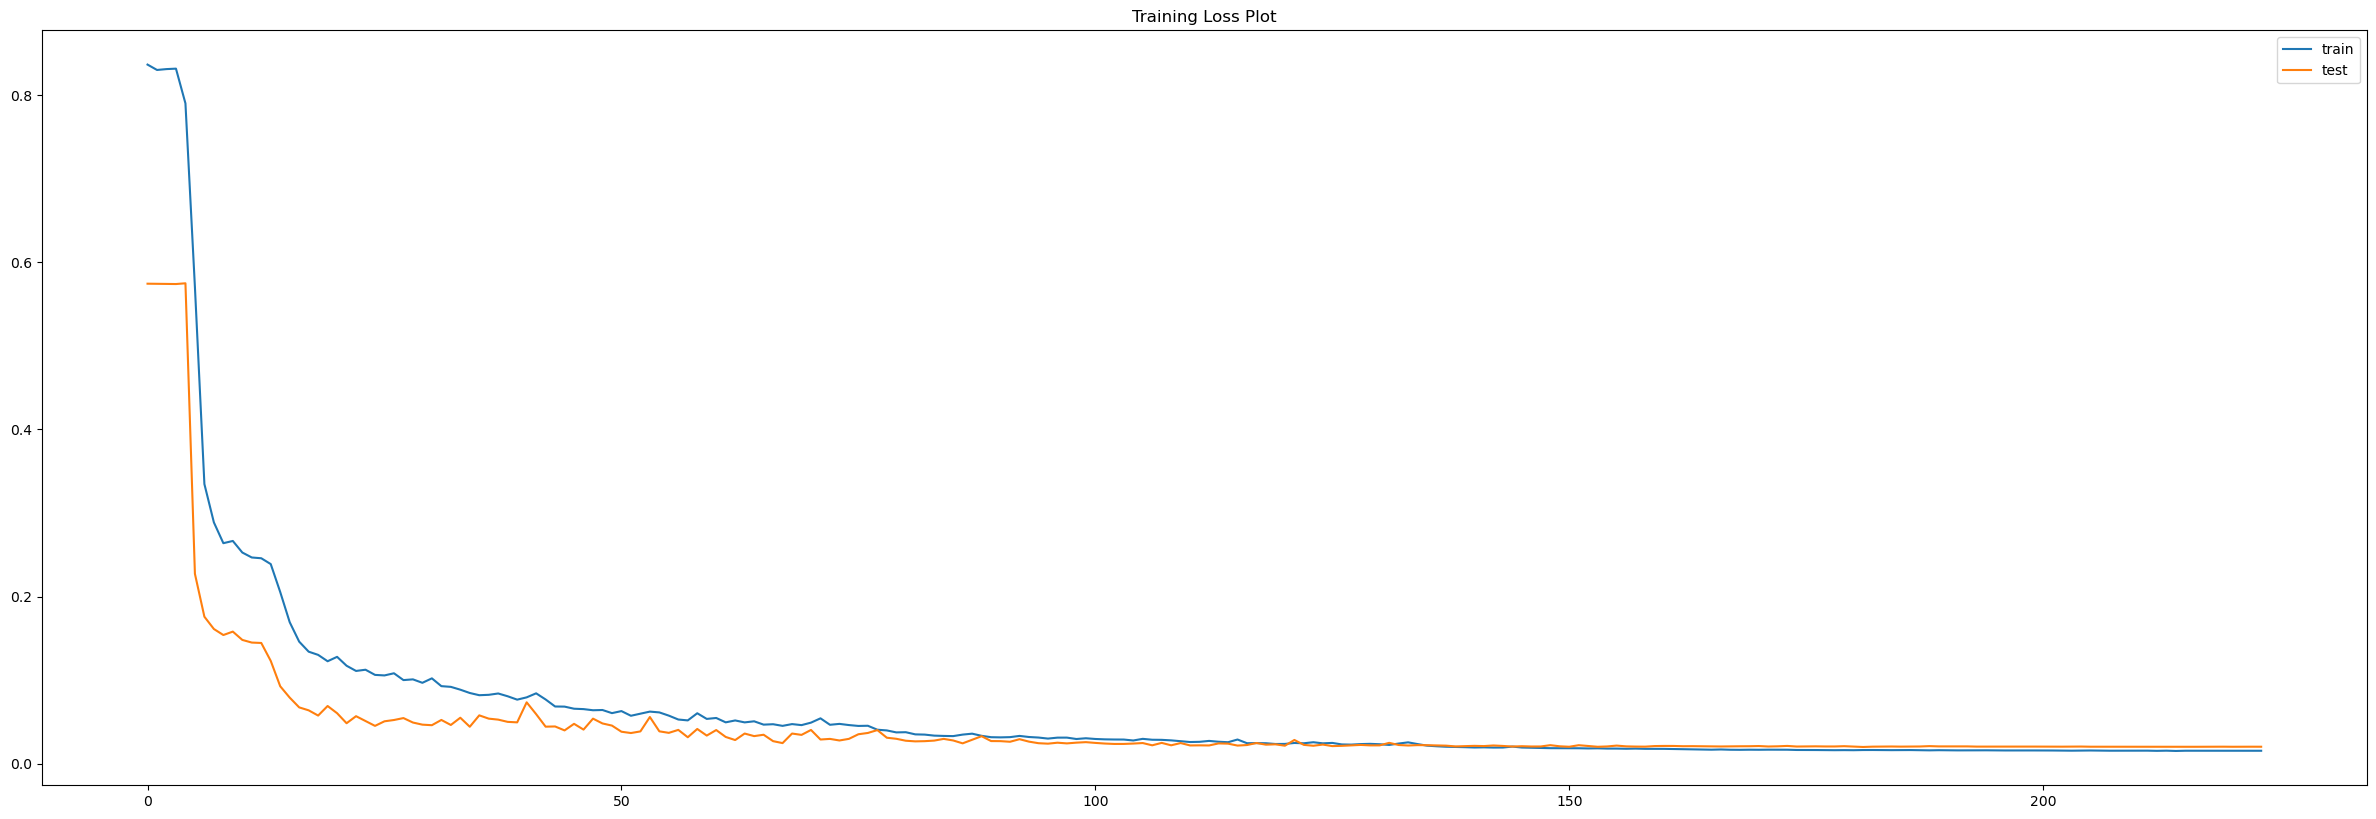

In [78]:
# plot history
pyplot.figure(figsize=(30, 10), dpi=100)
pyplot.title("Training Loss Plot")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [112]:
#Load Saved Model
saved_model = keras.models.load_model("model/model1_prev1_minmax_weights_best.h5")

In [113]:
#make a prediction
yhat = saved_model.predict(test_X)
test_X1 = test_X.reshape(-1,test_X.shape[2])
yhat = yhat.reshape(-1,1)

#invert scaling for forecast
inv_yhat = concatenate((test_X1[:,0:],yhat), axis=1)
inv_yhat = be.inverse_transform(inv_yhat)
inv_yhat[float_col_list] = rbs.inverse_transform(inv_yhat[float_col_list])
inv_yhat = inv_yhat.iloc[:,-1]

# invert scaling for actual
test_y1 = test_y.reshape(-1,1)
test_X1 = test_X.reshape(-1,test_X.shape[2])
inv_y = concatenate((test_X1[:,0:],test_y1), axis=1)
inv_y = be.inverse_transform(inv_y)
inv_y[float_col_list] = rbs.inverse_transform(inv_y[float_col_list])
inv_y = inv_y.iloc[:,-1]

In [114]:
# calculate RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat)/((24.0*60)**2))
print('Test RMSE in Days: %.3f' % rmse)

Test RMSE in Days: 0.995


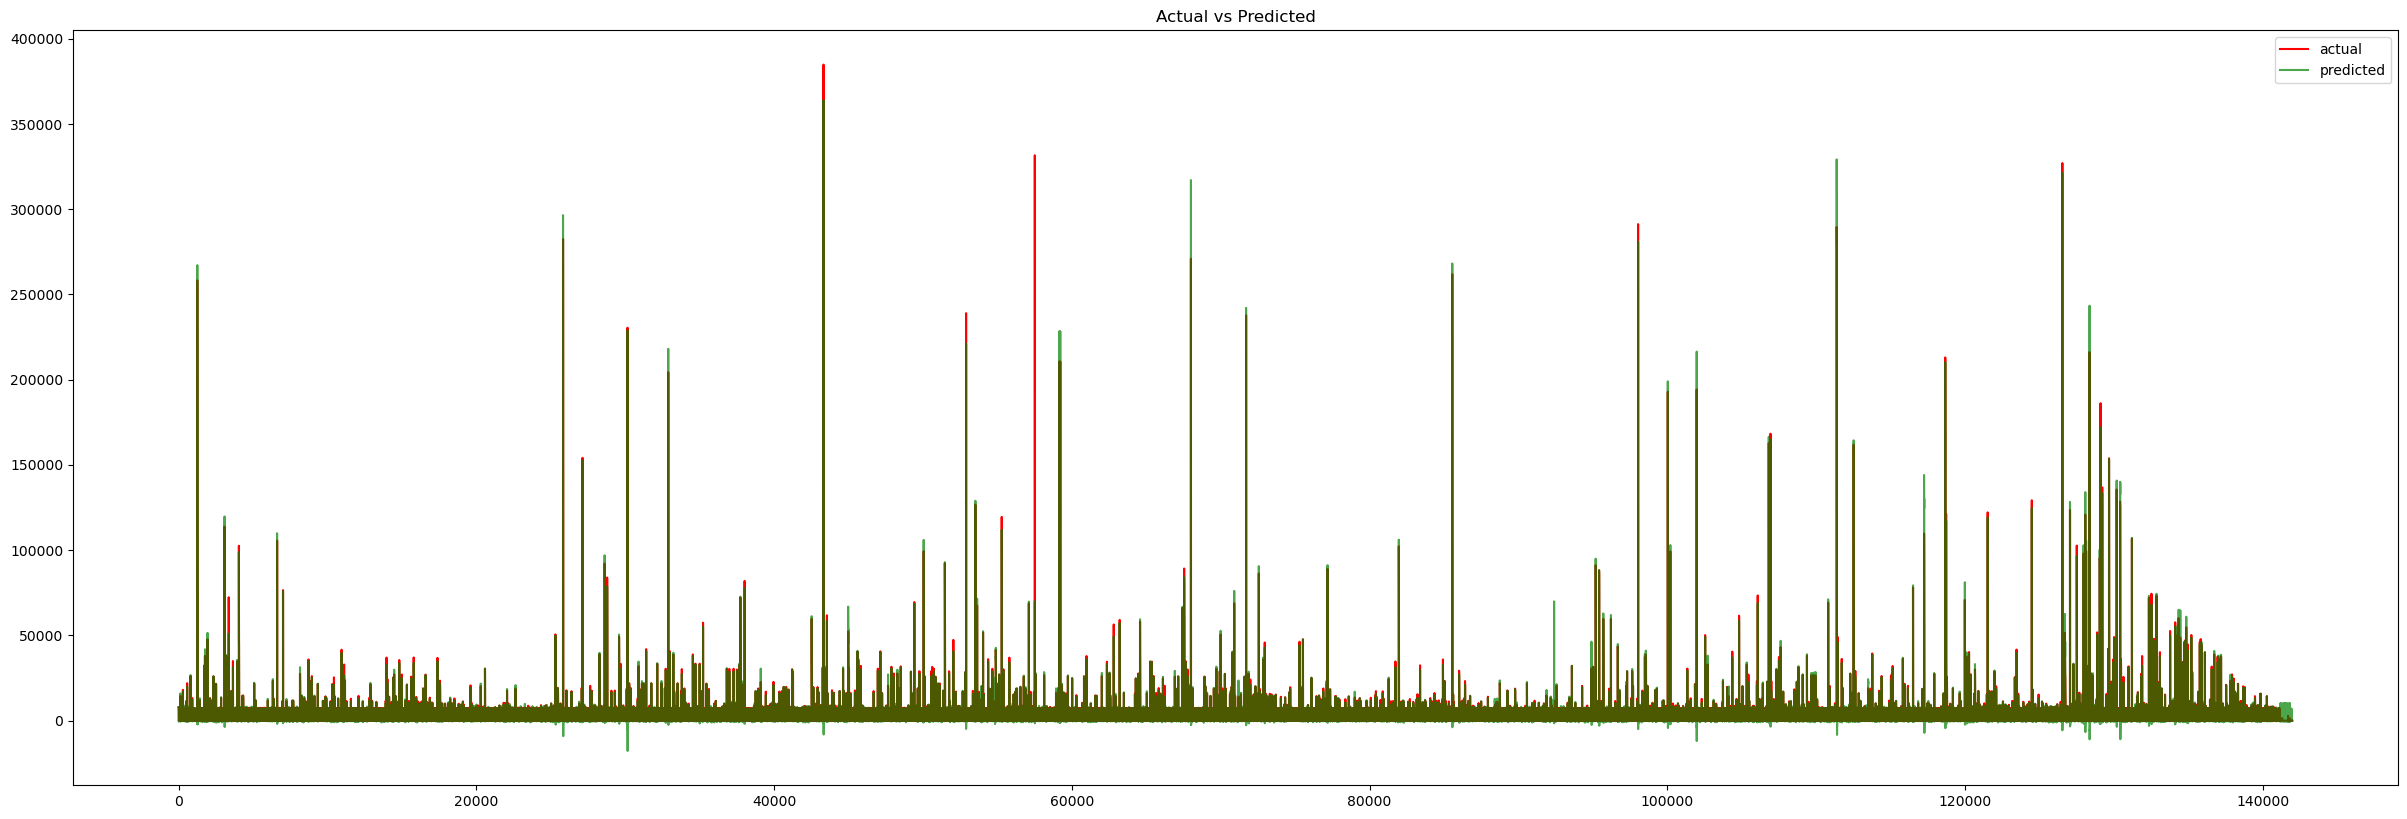

In [126]:
pyplot.figure(figsize=(30, 10), dpi=100)
pyplot.title("Actual vs Predicted")
pyplot.plot(inv_y, label='actual', alpha=1, c = 'red')
pyplot.plot(inv_yhat, label='predicted',c='green', alpha=0.7)
pyplot.legend()
pyplot.show()

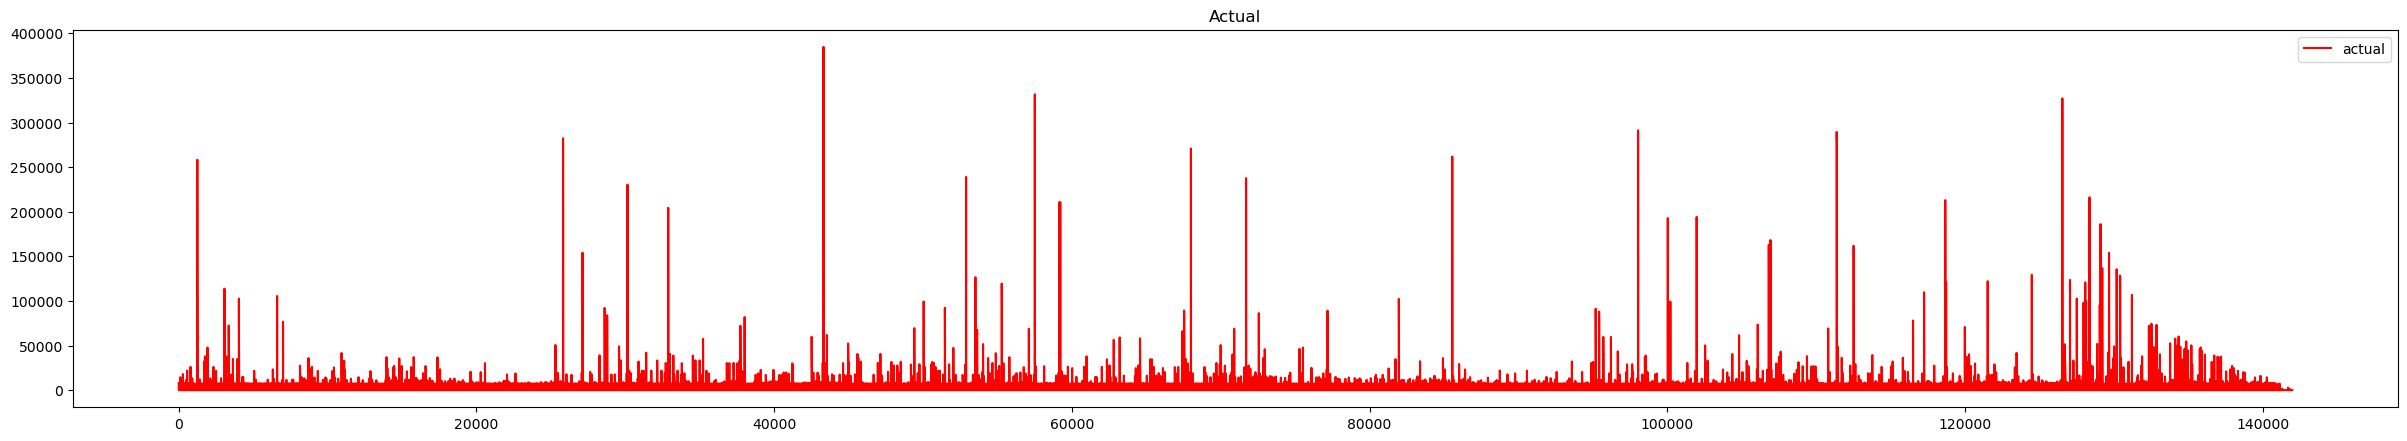

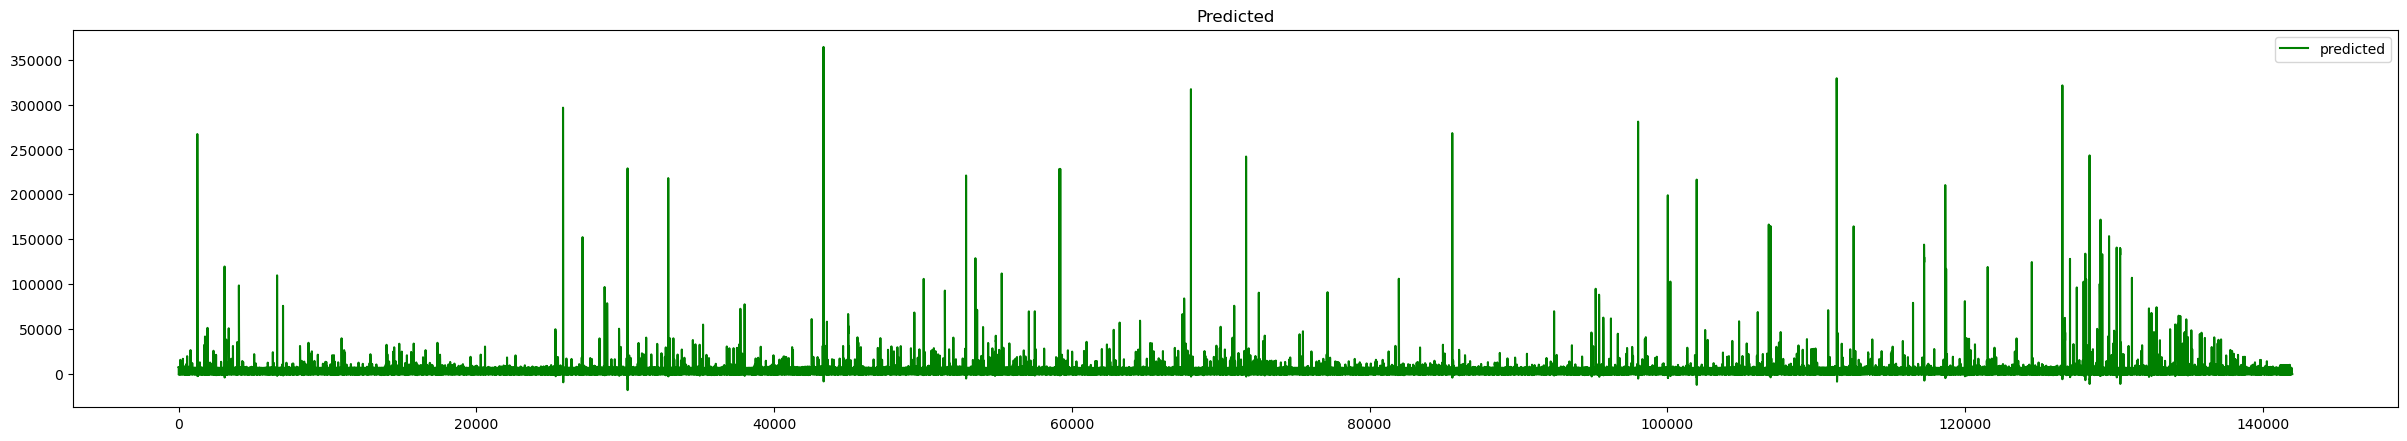

In [116]:
pyplot.figure(figsize=(30, 5), dpi=100)
pyplot.title("Actual")
pyplot.plot(inv_y, label='actual', alpha=1, c = 'red')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(30, 5), dpi=100)
pyplot.title("Predicted")
pyplot.plot(inv_yhat, label='predicted',c='green', alpha=1)
pyplot.legend()
pyplot.show()